In [1]:
import geemap
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pdb
from IPython.display import display
import ee
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pdb
from IPython.display import display
import os
import seaborn as sns
import statsmodels.formula.api as sm
from numpy.polynomial.polynomial import polyfit
from sklearn.model_selection import train_test_split
import sklearn
from math import sqrt
import glob

In [2]:
##PC:
path = r'C:/Users/arj26323/Documents/Data/Biomass datasets/Virginia/Yearly point extraction data' 
all_files = glob.glob(path + "/*.csv")

li = []

for filename in all_files:
    df = pd.read_csv(filename, index_col=None, header=0)
    li.append(df)

df = pd.concat(li, axis=0, ignore_index=True)
df['Sensor'] = np.where(df['Year']<2013, 'Landsat 5', 'Landsat 8') 
df['ndvi'] = np.where(df['Sensor'] == 'Landsat 5', (df['B4']-df['B3'])/(df['B4']+df['B3']), \
                      (df['B5']-df['B4'])/(df['B5']+df['B4']))
df['Blue_band'] = np.where(df['Sensor'] == 'Landsat 5', df['B1'], df['B2'])
df['Green_band'] = np.where(df['Sensor'] == 'Landsat 5', df['B2'], df['B3'])
df['Red_band'] = np.where(df['Sensor'] == 'Landsat 5', df['B3'], df['B4'])
df['NIR_band'] = np.where(df['Sensor'] == 'Landsat 5', df['B4'], df['B5'])
df['SWIR1_band'] = np.where(df['Sensor'] == 'Landsat 5', df['B5'], df['B6'])
df['SWIR2_band'] = np.where(df['Sensor'] == 'Landsat 5', df['B7'], df['B7'])
df['savi'] = ((df['NIR_band']-df['Red_band'])*1.5)/(df['NIR_band']+df['Red_band']+0.5)
df['wdrvi5'] = (0.5*df['NIR_band']-df['Red_band'])/(0.5*df['NIR_band']+df['Red_band'])
df['nd_r_g'] = (df['Red_band']-df['Green_band'])/(df['Red_band']+df['Green_band'])
df['nd_g_b'] = (df['Green_band']-df['Blue_band'])/(df['Green_band']+df['Blue_band'])
df['nd_swir2_nir'] = (df['SWIR2_band']-df['NIR_band'])/(df['SWIR2_band']+df['NIR_band'])
df['nd_swir2_r'] = (df['SWIR2_band']-df['Red_band'])/(df['SWIR2_band']+df['Red_band'])

df = df.drop(columns=['latitude','longitude'])
df['ident'] = df['Latitude'] / df['Longitude'] + df['Year'] 

##DAYMET data
path2 = r'C:/Users/arj26323/Documents/Data/Biomass datasets/Daymet/VA/Yearly averages' 
all_files2 = glob.glob(path2 + "/*.csv")

li = []

for filename in all_files2:
    dm = pd.read_csv(filename, index_col=None, header=0)
    li.append(dm)

dm = pd.concat(li, axis=0, ignore_index=True)
dm.rename(columns={'site_id':'siteName'}, inplace=True)
dm = dm.drop(columns=['latitude','longitude'])
dm['ident'] = dm['Latitude'] / dm['Longitude'] + dm['Year']

##TBD: Seasonal averages/growing season (defined as between 3/1 and 10/31)

##Loading elevation data
elev_10m = pd.read_csv('C:/Users/arj26323/Documents/Data/Biomass datasets/Virginia/Point elevation/VA_DEM_vals_10m.csv')
elev_10m.rename(columns={'first':'Elevation'}, inplace=True)
elev_10m.rename(columns={'site_id':'siteName'}, inplace=True)
elev_10m['ident'] = elev_10m['Latitude'] / elev_10m['Longitude'] + elev_10m['Year']

##Merging daymet, elevation, and flats data
df['dropident'] = df['Latitude']/df['Longitude']*df['Year']+df['liveMass']
dm['dropident'] = dm['Latitude']/dm['Longitude']*dm['Year']+dm['liveMass']
elev_10m['dropident'] = elev_10m['Latitude']/elev_10m['Longitude']*elev_10m['Year']+elev_10m['liveMass']

df0 = pd.merge(df, dm, on = ['dropident'], how = 'left')

df0['dropident'] = df0['Latitude_x']/df0['Longitude_x']*df0['Year_x']+df0['liveMass_x']
print(len(df0['dropident']))
df0 = df0.drop_duplicates(
  subset = ['dropident'],
  keep = 'last').reset_index(drop = True)
print(len(df0['dropident']))

##Merge with elevation
df1 = pd.merge(df0, elev_10m, on = ['dropident'], how = 'left')

df1['dropident'] = df1['Latitude_x']/df1['Longitude_x']*df1['Year_x']+df1['liveMass_x']
print(len(df1['dropident']))
df1 = df1.drop_duplicates(
  subset = ['dropident'],
  keep = 'last').reset_index(drop = True)
print(len(df1['dropident']))

##THIS NEEDS TO BE 0
print('df0 biomass diff is: '+str(sum(df0['liveMass_x'] - df0['liveMass_y'])))
print('df1 biomass diff (x-y) is: '+str(sum(df1['liveMass_x'] - df1['liveMass_y'])))
print('df1 biomass diff (x-z) is: '+str(sum(df1['liveMass_x'] - df1['liveMass'])))
# df1.rename(columns={'liveMass_x':'liveMass'}, inplace=True)

print("biomass measurements: " + str(len(df1['liveMass'])))
print(len(df1['Elevation'].unique()))

df1 = df1.drop(columns = ['latitude', 'longitude']) ##lower case ones are the older values

##Some more data massaging
df1 = df1[df1['ndvi'].notna()]
df1 = df1[df1['liveMass'].notna()]
df1 = df1[df1['Latitude'].notna()]
df1 = df1[(df1['flats'] < 0.1)] ##Double check

##Group df1 and average (midpoint) the replicates (a/b)
df_temp=df1.copy()

df_temp = df_temp.groupby(['Year','locationID','Transect','Latitude','Longitude'],as_index = False).aggregate(
    {
        'liveMass':[np.mean, np.size],'ndvi':[np.mean],'nd_swir2_r':[np.mean],'nd_swir2_nir':[np.mean],'nd_g_b':[np.mean],
        'nd_r_g':[np.mean],'wdrvi5':[np.mean],'savi':[np.mean],'Elevation':[np.mean],'prcp':[np.mean],'dayl':[np.mean],
        'tmax':[np.mean],'tmin':[np.mean],'srad':[np.mean],'vp':[np.mean]
    }
)

df_temp.columns = [
    'Year','locationID','Transect','Latitude','Longitude','liveMass','N','ndvi','nd_swir2_r','nd_swir2_nir', 'nd_g_b', 
    'nd_r_g', 'wdrvi5', 'savi', 'Elevation','prcp', 'dayl','tmax','tmin','srad','vp'
]

# display(df_temp)

##Machine learning
from sklearn.model_selection import train_test_split
from numpy import loadtxt
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import accuracy_score
from sklearn import metrics

df1 = df_temp ##Therein the rub! COMMENT OUT if you do not want to group replicates

xargs=df1[['ndvi', 'nd_swir2_r', 'nd_swir2_nir', 'nd_g_b', 'nd_r_g', 'wdrvi5', 'savi', 'Elevation', \
           'prcp', 'dayl', 'tmax', 'tmin', 'srad', 'vp']]

yargs=df1['liveMass'] 

print("biomass measurements: " + str(len(df1['liveMass'])))
print("yargs: " + str(len(yargs)))

size_x = 0.2
seed = 0
xargs_train, xargs_test, yargs_train, yargs_test = train_test_split(xargs, yargs, test_size=size_x, random_state = seed) 
## 80% training and 20% test

pipe = Pipeline([('scaler', StandardScaler()), ('forest', RandomForestRegressor(n_estimators=100, random_state=seed))])
pipe.fit(xargs_train, yargs_train)
y_pred=pipe.predict(xargs_test)
print('Mean Absolute Error:', metrics.mean_absolute_error(yargs_test, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(yargs_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(yargs_test, y_pred)))
r_square = metrics.r2_score(yargs_test, y_pred)
print("The r squared is: " + str(r_square))
print(r_square)
print('testing r2 is: ' + str(pipe.score(xargs_test, yargs_test)))
print('training r2 is: ' + str(pipe.score(xargs_train, yargs_train)))
print('NRMSE is: ' + str(np.sqrt(metrics.mean_squared_error(yargs_test, y_pred))/np.ptp(yargs_test)))

# Mean
print('MEAN BASELINE:')
y_pred_mean = [np.mean(yargs_train)] * len(yargs_test)
print('Mean Absolute Error:', metrics.mean_absolute_error(yargs_test, y_pred_mean))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(yargs_test, y_pred_mean)))

##FINAL MODEL: Can we remove this and use pipeline in the future?
from sklearn.ensemble import RandomForestRegressor
reg_x=RandomForestRegressor(n_estimators=90, random_state = 0) ##Won't let me do 100
# reg_x.fit(xargs_train, yargs_train)
reg_x.fit(xargs, yargs) ##training using all of the data! Splits/k-fold was for model development, not implementation

1900
1846
1864
1846
df0 biomass diff is: 0.0
df1 biomass diff (x-y) is: 0.0
df1 biomass diff (x-z) is: 0.0
biomass measurements: 1846
153
biomass measurements: 611
yargs: 611
Mean Absolute Error: 244.4763163917925
Mean Squared Error: 101013.61446608821
Root Mean Squared Error: 317.82639044939015
The r squared is: 0.1443168765939713
0.1443168765939713
testing r2 is: 0.1443168765939713
training r2 is: 0.875653720696323
NRMSE is: 0.18565840198038083
MEAN BASELINE:
Mean Absolute Error: 269.971056110889
Root Mean Squared Error: 343.5899165813627


RandomForestRegressor(n_estimators=90, random_state=0)

In [3]:
##GEE - getting scenes to predict
ee.Initialize()

#Landsat
va17 = ee.Image('LANDSAT/LC08/C01/T1_SR/LC08_014034_20170831')
va16 = ee.Image('LANDSAT/LC08/C01/T1_SR/LC08_014034_20160812')
va13 = ee.Image('LANDSAT/LC08/C01/T1_SR/LC08_014034_20130905')

def maskL5sr(image):
  ## Bits 3 and 5 are cloud shadow and cloud, respectively.
  cloudShadowBitMask = 1 << 3
  cloudsBitMask = 1 << 5

  ##Get the pixel QA band.
  qa = image.select('pixel_qa')

  ##Both flags should be set to zero, indicating clear conditions.
  mask = qa.bitwiseAnd(cloudShadowBitMask).eq(0) \
      .And(qa.bitwiseAnd(cloudsBitMask).eq(0))

  ##Return the masked image, scaled to reflectance, without the QA bands.
  return image.updateMask(mask).divide(10000) \
      .select("B[0-9]*") \
      .copyProperties(image, ["system:time_start"])

##Water masking

##Load or import the Hansen et al. forest change dataset.
hansenImage = ee.Image('UMD/hansen/global_forest_change_2015')

##Select the land/water mask.
datamask = hansenImage.select('datamask')

##Create a binary mask.
watermask = datamask.eq(1)

vamasked17 = ee.Image(maskL5sr(va17)).updateMask(watermask)
vamasked16 = ee.Image(maskL5sr(va16)).updateMask(watermask)
vamasked13 = ee.Image(maskL5sr(va13)).updateMask(watermask)

def addFLATS(image):
    flats = ee.Image(0).expression(
        '1-1/(1+2.718281828459045**(-1.57 + 19.97*(RED-NIR)/(RED+NIR) + 68.55*(GREEN-RED)/(GREEN+RED)))', {
            'NIR': image.select('B5'),
            'RED': image.select('B4'),
            'GREEN': image.select('B3')
        })
    
    return image.addBands(flats.rename('flats'))

FLAT17 = addFLATS(vamasked17)
FLAT16 = addFLATS(vamasked16)
FLAT13 = addFLATS(vamasked13)

#Daymet
daymet = ee.ImageCollection('NASA/ORNL/DAYMET_V4') \
     .filter(ee.Filter.date('2017-01-01', '2017-12-31')) \
     .mean()

roi = ee.Geometry.Point([-75.876094, 37.395746]).buffer(1000000)
daymet = daymet.clip(roi)

dm_precip = daymet.select('prcp')
dm_maxtemp = daymet.select('tmax')
dm_mintemp = daymet.select('tmin')
dm_daylight = daymet.select('dayl')
dm_srad = daymet.select('srad')
dm_snow = daymet.select('swe')
dm_vapor = daymet.select('vp')

prcpVis = {
  'min': -40.0,
  'max': 30.0,
  'palette': ['1621A2', 'white', 'cyan', 'green', 'yellow', 'orange', 'red'],
}

daylVis = {
  'min': 0,
  'max': 50000.0,
  'palette': ['1621A2', 'white', 'cyan', 'green', 'yellow', 'orange', 'red'],
}

sradVis = {
  'min': 0,
  'max': 400.0,
  'palette': ['1621A2', 'white', 'cyan', 'green', 'yellow', 'orange', 'red'],
}

vpVis = {
  'min': 0,
  'max': 1500,
  'palette': ['1621A2', 'white', 'cyan', 'green', 'yellow', 'orange', 'red'],
}

#DEM
dem2 = ee.Image('USGS/3DEP/10m')

dem2 = dem2.select(['elevation'], ['Elevation'])

dem2 = dem2.clip(roi)

dem_params = {
    'min': 0,
    'max': 4000,
    'palette': ['006633', 'E5FFCC', '662A00', 'D8D8D8', 'F5F5F5'],
}

Map = geemap.Map(center=[40,-100], zoom=4)

Map.addLayer(FLAT17, {'bands': ['B5',  'B4',  'B3'], 'min': 0, 'max': 0.2}, 'Flats 2017')
Map.addLayer(FLAT16, {'bands': ['B5',  'B4',  'B3'], 'min': 0, 'max': 0.2}, 'Flats 2017')

Map.addLayer(dem2, dem_params, '10m DEM', True, 1)
Map.addLayer(dm_precip, prcpVis, "prcp")
Map.addLayer(dm_maxtemp, prcpVis, "tmax")
Map.addLayer(dm_mintemp, prcpVis, "tmin")
Map.addLayer(dm_daylight, daylVis, "dayl")
Map.addLayer(dm_srad, sradVis, "srad")
Map.addLayer(dm_snow, prcpVis, "swe")
Map.addLayer(dm_vapor, vpVis, "vp")

Map

Map(center=[40, -100], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=HBox(children=(T…

In [4]:
##SN_DAYMET LAYER HERE

In [5]:
##Make all variables included in model ##WATCH OVER-MASKING

from geemap import ml

collection = ee.ImageCollection([daymet, FLAT17, dem2]) ##2019!

collection.getInfo()

img1 = ee.Image([daymet, FLAT17, dem2]) ##WILL ALSO NEED SN_DAYMET IN FUTURE

# Map.addLayer(collection, {}, 'collection')

##Land masking using NLCD:
dataset = ee.ImageCollection('USGS/NLCD_RELEASES/2019_REL/NLCD')
nlcd2019 = dataset.filter(ee.Filter.eq('system:index', '2019')).first() ## IS 2017 OR AN EARLIER YR AVAILABLE?
landcover = nlcd2019.select('landcover')
elev_set = dem2.select('Elevation')
elevmask = elev_set.updateMask(elev_set.lte(5)) ##Elevation masking - BE CAREFUL HERE!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

landcovermask = landcover.remap([31,95], [1,1]) ##90,11 removed. How to get land represented, just an unrelated color?

Map.addLayer(nlcd2019)

img1 = img1.updateMask(landcovermask)
# img1 = img1.updateMask(elevmask)

##Adding variables in LANDSAT 8:

def addsavi(image):
    savi = image.expression(
        '(1.5*(NIR-RED))/(RED+NIR+0.5)', {
            'NIR': image.select('B5'),
            'RED': image.select('B4'),
            'GREEN': image.select('B3')
        })
    
    return image.addBands(savi.rename('savi'))

def addwdrvi5(image):
    wdrvi5 = image.expression(
        '(0.5*NIR-RED)/(RED+NIR*0.5)', {
            'NIR': image.select('B5'),
            'RED': image.select('B4'),
            'GREEN': image.select('B3')
        })
    
    return image.addBands(wdrvi5.rename('wdrvi5'))

def addnd_r_g(image):
    nd_r_g = image.expression(
        '(RED-GREEN)/(RED+GREEN)', {
            'NIR': image.select('B5'),
            'RED': image.select('B4'),
            'GREEN': image.select('B3')
        })
    
    return image.addBands(nd_r_g.rename('nd_r_g'))

def addnd_g_b(image):
    nd_g_b = image.expression(
        '(GREEN-BLUE)/(BLUE+GREEN)', {
            'RED': image.select('B4'),
            'GREEN': image.select('B3'),
            'BLUE': image.select('B2')
        })
    
    return image.addBands(nd_g_b.rename('nd_g_b'))

def addnd_swir2_nir(image):
    nd_swir2_nir = image.expression(
        '(swir2-NIR)/(swir2+NIR)', {
            'NIR': image.select('B5'),
            'RED': image.select('B4'),
            'swir2': image.select('B7')
        })
    
    return image.addBands(nd_swir2_nir.rename('nd_swir2_nir'))

def addnd_swir2_r(image):
    nd_swir2_r = image.expression(
        '(swir2-RED)/(swir2+RED)', {
            'NIR': image.select('B5'),
            'RED': image.select('B4'),
            'swir2': image.select('B7')
        })
    
    return image.addBands(nd_swir2_r.rename('nd_swir2_r'))

def addndvi(image):
    ndvi = image.expression(
        '(NIR-RED)/(RED+NIR)', {
            'NIR': image.select('B5'),
            'RED': image.select('B4'),
            'GREEN': image.select('B3')
        })
    
    return image.addBands(ndvi.rename('ndvi'))

##REMEMBER: THIS IS ONLY LANDSAT 8! WILL NEED TO REDO BANDS FOR LS5 IMAGES
img1 = addsavi(img1)
img1 = addwdrvi5(img1)
img1 = addnd_r_g(img1)
img1 = addnd_g_b(img1)
img1 = addnd_swir2_nir(img1)
img1 = addnd_swir2_r(img1)
img1 = addndvi(img1)

Map.addLayer(img1, {}, 'img1')

feature_names = ['ndvi', 'nd_swir2_r', 'nd_swir2_nir', 'nd_g_b', 'nd_r_g', 'wdrvi5', 'savi', 'Elevation', \
           'prcp', 'dayl', 'tmax', 'tmin', 'srad', 'vp']

In [6]:
# ##Make all variables included in model ##WATCH OVER-MASKING

# from geemap import ml

# collection = ee.ImageCollection([daymet, FLAT19, dem2]) ##2019!

# collection.getInfo()

# img1 = ee.Image([daymet, FLAT19, dem2])

# # Map.addLayer(collection, {}, 'collection')

# ##Land masking using NLCD:
# dataset = ee.ImageCollection('USGS/NLCD_RELEASES/2019_REL/NLCD')
# nlcd2019 = dataset.filter(ee.Filter.eq('system:index', '2019')).first() ##use different NLCD image for earlier years
# landcover = nlcd2019.select('landcover')
# elev_set = dem2.select('Elevation')
# elevmask = elev_set.updateMask(elev_set.lte(2)) ##Elevation masking - BE CAREFUL HERE!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

# landcovermask = landcover.remap([31,95], [1,1]) ##90,11 removed. How to get land represented, just an unrelated color?

# img1 = img1.updateMask(landcovermask)
# img1 = img1.updateMask(elevmask)


##Adding variables in LANDSAT 5:

def L5addsavi(image):
    savi = image.expression(
        '(1.5*(NIR-RED))/(RED+NIR+0.5)', {
            'NIR': image.select('B4'),
            'RED': image.select('B3'),
            'GREEN': image.select('B2')
        })
    
    return image.addBands(savi.rename('savi'))

def L5addwdrvi5(image):
    wdrvi5 = image.expression(
        '(0.5*NIR-RED)/(RED+NIR*0.5)', {
            'NIR': image.select('B4'),
            'RED': image.select('B3'),
            'GREEN': image.select('B2')
        })
    
    return image.addBands(wdrvi5.rename('wdrvi5'))

def L5addnd_r_g(image):
    nd_r_g = image.expression(
        '(RED-GREEN)/(RED+GREEN)', {
            'NIR': image.select('B4'),
            'RED': image.select('B3'),
            'GREEN': image.select('B2')
        })
    
    return image.addBands(nd_r_g.rename('nd_r_g'))

def L5addnd_g_b(image):
    nd_g_b = image.expression(
        '(GREEN-BLUE)/(BLUE+GREEN)', {
            'RED': image.select('B3'),
            'GREEN': image.select('B2'),
            'BLUE': image.select('B1')
        })
    
    return image.addBands(nd_g_b.rename('nd_g_b'))

def L5addnd_swir2_nir(image):
    nd_swir2_nir = image.expression(
        '(swir2-NIR)/(swir2+NIR)', {
            'NIR': image.select('B4'),
            'RED': image.select('B3'),
            'swir2': image.select('B7')
        })
    
    return image.addBands(nd_swir2_nir.rename('nd_swir2_nir'))

def L5addnd_swir2_r(image):
    nd_swir2_r = image.expression(
        '(swir2-RED)/(swir2+RED)', {
            'NIR': image.select('B4'),
            'RED': image.select('B3'),
            'swir2': image.select('B7')
        })
    
    return image.addBands(nd_swir2_r.rename('nd_swir2_r'))

def L5addndvi(image):
    ndvi = image.expression(
        '(NIR-RED)/(RED+NIR)', {
            'NIR': image.select('B4'),
            'RED': image.select('B3'),
            'GREEN': image.select('B2')
        })
    
    return image.addBands(ndvi.rename('ndvi'))

# img1 = addsavi(img1)
# img1 = addwdrvi5(img1)
# img1 = addnd_r_g(img1)
# img1 = addnd_g_b(img1)
# img1 = addnd_swir2_nir(img1)
# img1 = addnd_swir2_r(img1)
# img1 = addndvi(img1)

# Map.addLayer(img1, {}, 'img1')

# feature_names = ['ndvi', 'nd_swir2_r', 'nd_swir2_nir', 'nd_g_b', 'nd_r_g', 'wdrvi5', 'savi', 'Elevation', \
#            'prcp', 'dayl', 'tmax', 'tmin', 'srad', 'vp']

In [7]:
##Incorporating ML model into geemap (takes some time)

##Model implementation - can we get 'pipe' in here??
trees = ml.rf_to_strings(reg_x, feature_names, output_mode="REGRESSION")

# print(trees[0])
n_trees = 90
len(trees) == n_trees

# create a ee classifier to use with ee objects from the trees
ee_classifier = ml.strings_to_classifier(trees)

classified = img1.select(feature_names).classify(ee_classifier)

# classified = img1.select(feature_names).classify(pipe)

In [8]:
import geemap.colormaps as cm
roi2 = ee.Geometry.Point([-75.876094, 37.395746]).buffer(20000)
palette = cm.palettes.BuGn

Map.addLayer(
    classified.clip(roi2),
    {"min": 0, "max": 1500, 'palette': palette},
    'classification',
)

# Map.add_legend(title='Spartina alterniflora biomass', labels=classified.select('classification'), colors=palette)

Map

# cm.list_colormaps()

Map(center=[40, -100], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=HBox(children=(T…

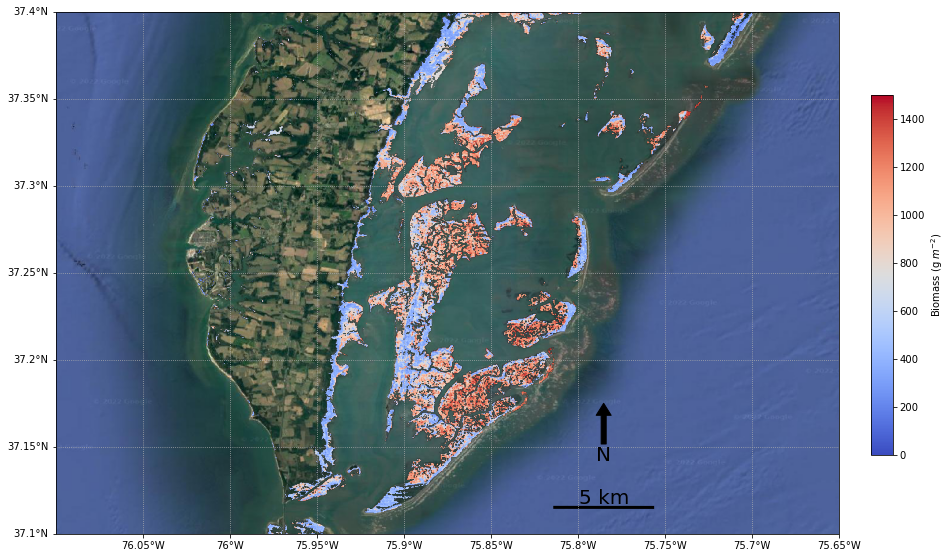

In [9]:
##Cartoee
from geemap import cartoee

# geospatial region in format [E,S,W,N]
region = [-76.174, 37.1, -75.212, 37.818]
 # define bounding box to request data
out_region = [180, -60, -180, 85]
zoom_region = [-75.65, 37.1, -76.1, 37.4]
ultrazoom_region = [-75.85, 37.15, -75.9, 37.2]
##Why are coordinates changing based on zoom level?? Projection issue?

# vis = {'min': 0, 'max': 1500, 'palette': ['1621A2', 'white', 'blue', 'cyan', 'green']}  # define vis parameters for image
vis = {'min': 0, 'max': 1500}  # define vis parameters for image

cmap = "coolwarm"

fig = plt.figure(figsize=(15, 10))

# use cartoee to get a map
ax = cartoee.get_map(classified, region=zoom_region, vis_params=vis, cmap = cmap, basemap='SATELLITE', zoom_level=12)

# add a colorbar to the map using the visualization params we passed to the map
cartoee.add_colorbar(ax, vis, cmap = cmap, loc="right", label="Biomass (g $m^{-2}$)", orientation="vertical")

# add gridlines to the map at a specified interval
cartoee.add_gridlines(ax, interval=[0.05, 0.05], linestyle=":")

# add coastlines using the cartopy api - way off! check with zoomed out image
# ax.coastlines(color="red")

# add north arrow
cartoee.add_north_arrow(
    ax, text="N", xy=(0.7, 0.25), text_color="black", arrow_color="black", fontsize=20
)

# add scale bar
cartoee.add_scale_bar_lite(
    ax, length=5, xy=(0.7, 0.05), fontsize=20, color="black", unit="km"
)

##More info here: https://geemap.org/notebooks/50_cartoee_quickstart/#plotting-an-image
##And here: https://geemap.org/notebooks/66_cartoee_legend/

In [ ]:
##Notes on map: Need to mask out land; right now biomass seems rather high (especially for... sand)